# Problem 3: Google Playstore Apps Dataset (63 points)
Given an Excel data file as represented by the sample file GooglePlaystore.xlsx (10K records), load it into a Pandas DataFrame (use the Pandas read_excel method), and perform the following tasks on it. 

In [1]:
import numpy as np
import pandas as pd
from pandas import Series
from pandas import DataFrame
import matplotlib.pyplot as plt

df = pd.read_excel('GooglePlaystore.xlsx')

## Preprocessing (28 pts)

1. [3 pts] Often there are outliers which do not match the overall data type. There is one record in this data where the "Reviews" has value "3.0M" which does not match the rest of the data. Remove that record. 

In [2]:
df.drop(df[df['Reviews'] == '3.0M'].index, inplace=True)

2. [4 pts] Remove rows where any of the columns has the value "Varies with device". 

In [3]:
df = df[(df != 'Varies with device').all(axis=1)]

3. [5 pts] The values in the Android version column should be floats. Strip the trailing non-numeric characters from all values (ie. the words " and up"), so the result is a number. If there are multiple decimal places (eg. "x.y.z"), keep only the first two parts (eg "x.y").

In [4]:
df['Android Ver'] = df['Android Ver'].str[:3].astype(float)

4. [5 pts] The "Installs" column must have integer values. For values that have commas, remove the commas. For values that have a '+' at the end, remove the '+'. Keep only those rows that have an integer value after these edits. 

In [5]:
#PROCESS: 
    #convert installs to numeric (if value cannot be converted, it becomes NA) 
    #if installs column dtype is not int64 (column contains NAs or floats):
        #drop NA and non-whole numbers, convert to int
df['Installs'] = pd.to_numeric(df['Installs'].str.replace('[+,]', '', regex=True), errors='coerce')
if (df['Installs'].dtype != 'int64'):
    df['Installs'] = df[df['Installs'].apply(lambda x : x.is_integer())].astype(int)

5. [5 pts] For missing rating values, if the number of reviews is less than 100 and installations is less than 50000, remove the row. Else, fill the missing value with the average value (rounded to 2 decimal places) for the Category of that row.

In [6]:
df.drop(df[(df['Reviews'] < 100) & (df['Installs'] < 50000) & (df['Rating'].isnull())].index, inplace=True)
cat_ratings = df.groupby('Category')['Rating'].mean()
for cat in cat_ratings.index:
    df.loc[df['Category'] == cat, 'Rating'] = df.loc[df['Category'] == cat, 'Rating'].fillna(cat_ratings.loc[[cat]][0].round(2))

6. [6 pts] Preprocess the Size column to convert the "M" (millions) and "K" (thousands) values into integers. For instance, 8.7M should be converted to 8700000 and 2.4K should be converted to 2400. 

In [7]:
def convert_size(x):
    if x[-1].upper() == 'M': return int(float(x[:-1]) * 1000000)
    elif x[-1].upper() == 'K': return int(float(x[:-1]) * 1000)
    else: return int(x)

df['Size'] = df['Size'].apply(convert_size)

## Analysis (19 pts)

1. [4 pts] Describe (use DataFrame describe method) the category wise rating statistics. In other words, for each category, describe the statistics (count, mean, etc.) for ratings in that category. 

In [8]:
# Group the data by category and describe the rating statistics for each category
category_rating_stats = df.groupby('Category')['Rating'].describe()

# Display the statistics
print(category_rating_stats)

                      count      mean       std  min    25%   50%    75%  max
Category                                                                     
ART_AND_DESIGN         59.0  4.358644  0.365322  3.2  4.100  4.40  4.700  5.0
AUTO_AND_VEHICLES      62.0  4.146774  0.569935  2.1  3.900  4.25  4.500  4.9
BEAUTY                 40.0  4.291750  0.356175  3.1  4.075  4.30  4.525  4.9
BOOKS_AND_REFERENCE   147.0  4.320136  0.453084  2.7  4.100  4.40  4.600  5.0
BUSINESS              246.0  4.119187  0.662586  1.0  3.825  4.30  4.500  5.0
COMICS                 49.0  4.154082  0.550363  2.8  3.800  4.40  4.600  5.0
COMMUNICATION         210.0  4.100952  0.502624  1.0  3.900  4.20  4.400  5.0
DATING                174.0  3.957816  0.664204  1.0  3.600  4.10  4.400  5.0
EDUCATION             110.0  4.392636  0.254395  3.5  4.300  4.40  4.600  4.9
ENTERTAINMENT          86.0  4.145349  0.291308  3.0  4.000  4.20  4.300  4.7
EVENTS                 36.0  4.474167  0.340037  3.7  4.300  4.5

2. [11 pts] Extract all "Free" apps from the master data frame. Then write a function that, given a numeric column (e.g 'Rating'), will create and return a dataframe for the top 3 free applications in each category based on that column. Call the function on each of these columns (no tiebreaking necessary):   
    &emsp; a. Rating (gives top 3 most highly rated applications in each category)  
    &emsp; b. Installs (gives top 3 most installed applications in each category)  
    &emsp; c. Reviews (gives top 3 most reviewed applications in each category)   

In [9]:
def top_3_apps_by_column(df, column_name):
    # Function to return the top 3 apps in each category based on a specified column
    # and select only 'Category', 'App', and the specified column for the output DataFrame
    top_3_apps_list = []
    for _, group in df.groupby('Category'):
        top_3_apps = group.sort_values(by=column_name, ascending=False).head(3)
        top_3_apps = top_3_apps[['Category', 'App', column_name]]
        top_3_apps_list.append(top_3_apps)
    
    # Concatenate all the top 3 DataFrames into a single DataFrame
    top_3_apps_df = pd.concat(top_3_apps_list, ignore_index=True)
    return top_3_apps_df

# Assuming df is your main DataFrame and it's already loaded

# Filter for free apps
free_apps_df = df[df['Price'] == 0]

# Call the function for 'Rating', 'Installs', and 'Reviews' and store the results
top_rated_free_apps = top_3_apps_by_column(free_apps_df, 'Rating')
top_installed_free_apps = top_3_apps_by_column(free_apps_df, 'Installs')
top_reviewed_free_apps = top_3_apps_by_column(free_apps_df, 'Reviews')

# Display the results
print("Top 3 RATED Free Apps in Each Category:")
print(top_rated_free_apps.head())  # Using .head() to display the first few rows

print("\nTop 3 INSTALLED Free Apps in Each Category:")
print(top_installed_free_apps.head())

print("\nTop 3 REVIEWED Free Apps in Each Category:")
print(top_reviewed_free_apps.head())

Top 3 RATED Free Apps in Each Category:
            Category                                      App  Rating
0     ART_AND_DESIGN  Spring flowers theme couleurs d t space     5.0
1     ART_AND_DESIGN     Fantasy theme dark bw black building     4.8
2     ART_AND_DESIGN                        Cardi B Wallpaper     4.8
3  AUTO_AND_VEHICLES    DMV Permit Practice Test 2018 Edition     4.9
4  AUTO_AND_VEHICLES                  Tickets + PDA 2018 Exam     4.9

Top 3 INSTALLED Free Apps in Each Category:
            Category                                                App  \
0     ART_AND_DESIGN                                       ibis Paint X   
1     ART_AND_DESIGN                     Tattoo Name On My Photo Editor   
2     ART_AND_DESIGN  Canva: Poster, banner, card maker & graphic de...   
3  AUTO_AND_VEHICLES                      AutoScout24 - used car finder   
4  AUTO_AND_VEHICLES  Fines of the State Traffic Safety Inspectorate...   

   Installs  
0  10000000  
1  10000000  
2 

3. [4 pts] Find the average, maximum and minimum price of the paid applications. 

In [10]:
# Filter the DataFrame for paid apps
paid_apps_df = df[df['Price'] > 0]

# Calculate the average, maximum, and minimum price of paid apps
average_price = paid_apps_df['Price'].mean()
max_price = paid_apps_df['Price'].max()
min_price = paid_apps_df['Price'].min()

# Display the results
print(f"Average Price of Paid Applications: ${average_price:.2f}")
print(f"Maximum Price of Paid Applications: ${max_price:.2f}")
print(f"Minimum Price of Paid Applications: ${min_price:.2f}")

Average Price of Paid Applications: $15.14
Maximum Price of Paid Applications: $400.00
Minimum Price of Paid Applications: $0.99


## Visualization (16 pts)

1. [9 pts] In the genre column, break the string of genres into a list. For example, ‘Art & Design; Creativity’ should be [‘Art & Design’, Creativity’].  Count the number of applications per genre and display it using a pie chart.


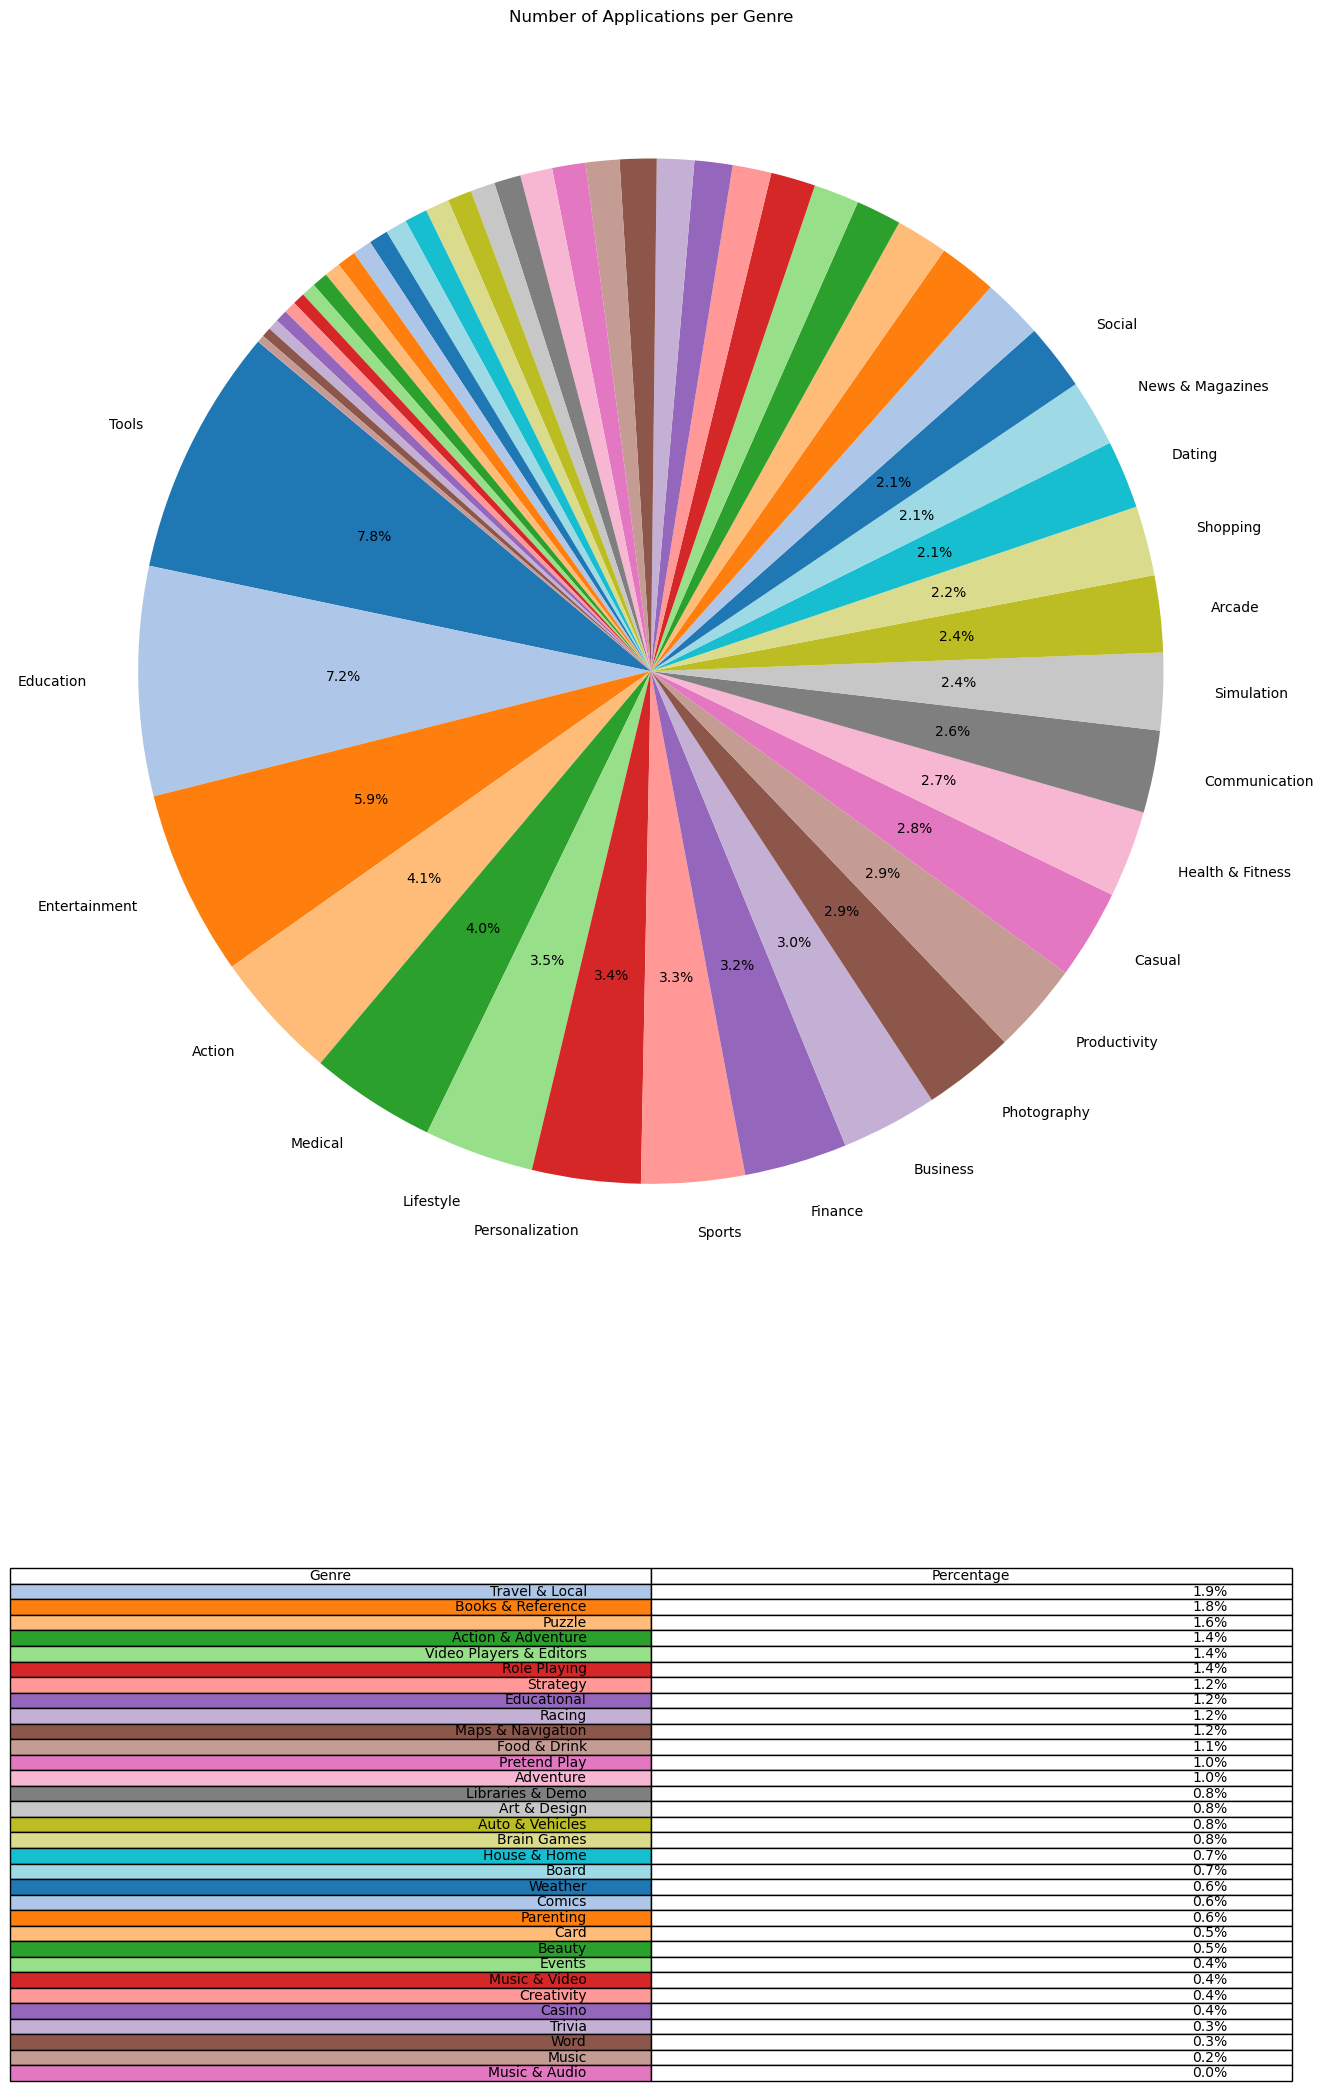

In [43]:
# Split the 'Genre' string into a list of genres
df['Genre'] = df['Genres'].str.split("\s*;\s*")

# Explode the 'Genre' list into separate rows
exploded_df = df.explode('Genre')

# Count the number of applications per genre
genre_counts = exploded_df['Genre'].value_counts()

# Calculate percentages for each genre
percentages = 100 * genre_counts / genre_counts.sum()

# Initialize lists for table data
table_genres = []
table_colors = []
table_percents = []

# Plot a pie chart
fig, ax = plt.subplots(figsize=(20, 15))
wedges, texts, autotexts = ax.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)

# Customize Labels and Prepare Table Data
for autotext, text, percentage, wedge in zip(autotexts, texts, percentages, wedges):
    if percentage <= 2:
        # Collect data for the table
        table_genres.append(text.get_text())
        table_colors.append(wedge.get_facecolor())
        table_percents.append(f'{percentage:.1f}%')
        
        # Remove the label and percentage from the pie chart
        autotext.set_text('')
        text.set_text('')

# Create a Table for Small Percentages
if table_genres:
    # Each row in the table data should be a list
    table_data = [[genre, percent] for genre, percent in zip(table_genres, table_percents)]
    table_colors = [[color, 'w'] for color in table_colors]  # Each row has two cells: genre (colored) and percentage (white)
    
    # Add a table at the bottom of the axes
    ax.table(cellText=table_data,
             cellColours=table_colors,
             colLabels=['Genre', 'Percentage'],
             loc='bottom',
             # bbox=[0.0, -0.5, 1.0, 0.3])  # Adjust bbox for layout
    
             bbox=[0.0, -0.6, 1.0, 0.4])  # Adjusted bbox: lower height, moved down

# Final Adjustments
ax.set_title('Number of Applications per Genre')
ax.set_ylabel('')  # Hide the y-label

plt.tight_layout(rect=[0, -0.4, 1, 0.95])  # Adjusted rect: more space at the bottom, slight reduction at the top
plt.show()

2. [7 pts] Display a box plot of ratings for "Business" and "Education" categories. The boxplots should be in the same plot.

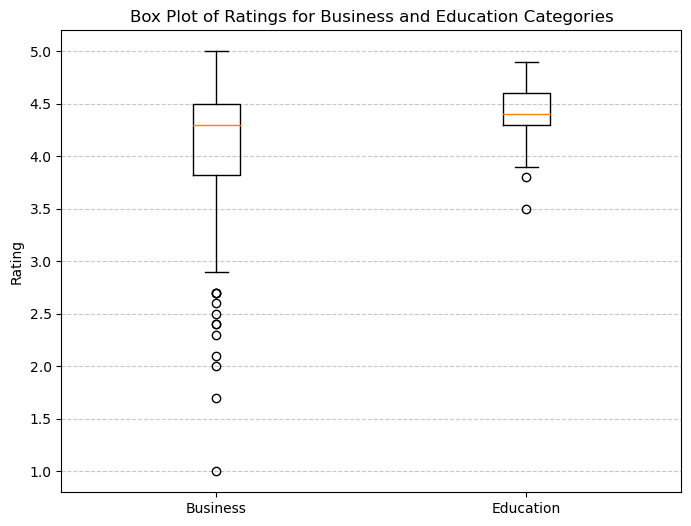

In [46]:
# Filter the DataFrame for 'Business' and 'Education' categories
business_ratings = df[(df['Category'] == 'BUSINESS')]['Rating'].dropna()
education_ratings = df[(df['Category'] == 'EDUCATION')]['Rating'].dropna()

# Prepare data for the box plot
data = [business_ratings, education_ratings]
labels = ['Business', 'Education']

# Create a box plot
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=labels)
plt.title('Box Plot of Ratings for Business and Education Categories')
plt.ylabel('Rating')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()